# Regressão Logística nos dados covtype de LIBSVM

Iremos treinar os dados para classificação binária usando os dados `covtype` da biblioteca [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Veja também [Kaggle-LIBSVM](https://www.kaggle.com/code/tanmayunhale/libsvm-liblinear).

Queremos minimizar

$$
\min_{w\in {\mathbb R}^{d\times1}} f(w)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(x_i^\top w)) + (1 - y_i) \log (1 - s(x_i^\top w))\right) + \frac{\gamma}{2}\|w\|^2,
$$

onde $x_i\in {\mathbb R}^{d\times1}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ é a função sigmóide. O gradiente é dado por

$$
\nabla f(w) = \frac{1}{n}\sum_{i=1}^n x_i(s(x_i^\top w)-y_i) + \gamma w.
$$

Esta é uma função suave com constante de Lipschitz $L=L_0+\gamma$ onde

$$
L_0 = \frac{1}{4}\lambda_{\max}\left(\frac{X^\top X}{n}\right),
$$ 

onde $X\in\mathbb{R}^{n\times d}$ é a matriz de dados cuja $i$-ézima linha é o vetor $x_i^\top$ e $\lambda_{\max}(\cdot)$ denota o maior autovalor.

In [ ]:
# Importação de módulos necesserários:

import matplotlib
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file
from sklearn.utils.extmath import safe_sparse_dot

In [4]:
# Lendo os dados do arquivo covtype e guardando na matriz de dados X e vetor de labels y:

data = load_svmlight_file('covtype')
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Devemos garantir que os labels estão em {0, 1}
    y -= 1    
    
n, d = X.shape # tamanho da amostra, número de features    

# Exercício 1: Funções auxiliares

1. Construa uma função `smoothness(X)` que toma a matriz de dados `X` e retorna a constante $L_0$.
2. Construa uma função `f(w, X, y, l2)` que toma o iterado `w`, os dados `X, y` e a penalização $\gamma$ (=`l2`) e retorna o valor funcional $f(w)$.
3. Construa uma função `df(w, X, y, l2)` toma o iterado `w`, os dados `X, y` e a penalização $\gamma$ (=`l2`) e retorna o gradiente $\nabla f(w)$.

In [5]:
# Função para calcular a constante L_0 de suavidade
def smoothness(X):
    n = X.shape[0]
    XTX = safe_sparse_dot(X.T, X) / n  # Multiplicação matricial compatível com dados esparsos
    L0 = (1 / 4) * la.eigvalsh(XTX).max()
    return L0

# Função de custo com regularização
def f(w, X, y, l2):
    n = X.shape[0]
    z = safe_sparse_dot(X, w)
    log_likelihood = y * np.log(1 / (1 + np.exp(-z))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-z)))
    regularization = (l2 / 2) * np.sum(w ** 2)
    return -np.mean(log_likelihood) + regularization

# Gradiente da função de custo com regularização
def df(w, X, y, l2):
    n = X.shape[0]
    z = safe_sparse_dot(X, w)
    sigmoid = 1 / (1 + np.exp(-z))
    gradient = (safe_sparse_dot(X.T, sigmoid - y)) / n + l2 * w
    return gradient

# Inicialização

Fixaremos:

In [6]:
L0 = smoothness(X)
l2 = L0 / n
L = L0 + l2
w0 = np.zeros(d)        # ponto inicial
it_max = 10000          # número de iterações

#Função de desempenho é a norma de Frobenius:
J = lambda w: la.norm(w)

#Função que retorna gradiente (para X,y,l2) já declarados.
def Df(w):
    return df(w, X, y, l2)

l2

8.676367672880712

# Exercício 2: Método do gradiente

Construa uma função `gd(df, w0, la=1, numb_iter=100)` que toma como entrada as funções `J()` `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `w0`. Esta função deve retornar a sequência de valores da função $\Vert\nabla f(w)\Vert_2$ em cada um dos iterados $w$. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` 

In [ ]:
# Função do método do gradiente
def gd(J, Df, w0, la=1, numb_iter=100):
    w = w0.copy()  
    grad_norms = []  

    for i in range(numb_iter):
        grad = Df(w) 
        grad_norm = np.linalg.norm(grad)  
        grad_norms.append(grad_norm)  
        
        # Atualiza o iterado w
        w -= la * grad  

    return grad_norms, w  

In [12]:
# gradient descent
f1 = gd(J, Df, w0, la=1./L, numb_iter=it_max)

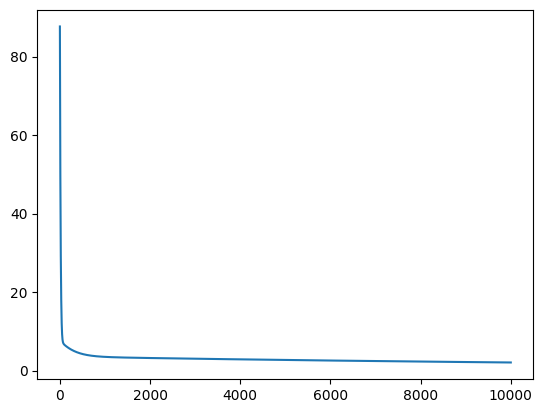

In [13]:
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, w0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `w0` e $t_0=1$:
\begin{align*}
w_{k+1}&:= y_k - la\nabla f(y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
y_{k+1} &:= w_{k+1} + \frac{t_{k}-1}{t_{k+1}}(w_{k+1}-w_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L`.

In [ ]:
# Função do método do gradiente acelerado de Nesterov
def accel_gd(J, df, w0, la=1, numb_iter=100):
    w = w0.copy()  
    y = w0.copy()  
    t = 1  # t0
    grad_norms = []  

    for k in range(numb_iter):
        grad = df(y)  
        grad_norm = np.linalg.norm(grad)  
        grad_norms.append(grad_norm)  

        # Atualiza w usando o gradiente em y
        w_next = y - la * grad

        # Calcula t_k+1
        t_next = (1 + np.sqrt(1 + 4 * t**2)) / 2

        # Atualiza y para a próxima iteração
        y = w_next + ((t - 1) / t_next) * (w_next - w)

        # Atualiza w e t para a próxima iteração
        w = w_next
        t = t_next

    return grad_norms, y

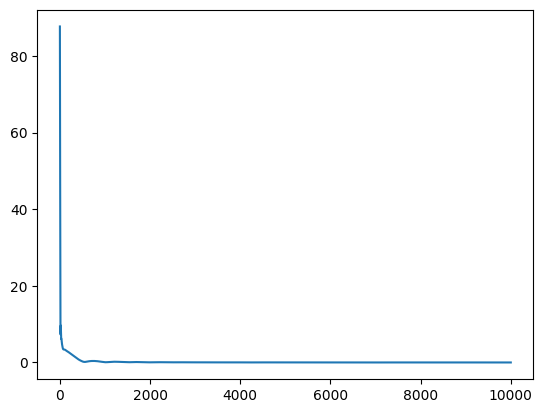

In [15]:
# Nesterov accelerated gradient descent
f2 = accel_gd(J, Df, w0, la=1./L, numb_iter=it_max)
plt.plot(f2[0])

# Exercício 4: Método do gradiente acelerado com $\gamma$

Construa uma função `accel_gd_sc(J, df, w0, la=1, kappa, numb_iter=100)` que toma como entrada as funções `J()`, `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y0=w0`:
\begin{align*}
w_{k+1}&:= y_k - la\nabla f(y_k),\\
y_{k+1} &:= w_{k+1} + \frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}(w_{k+1}-w_{k}).
\end{align*}
Àcima, $\kappa:=L/\gamma$. Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L`.

In [16]:
# Função do método do gradiente acelerado de Nesterov para funções fortemente convexas
def accel_gd_sc(J, df, w0, la=1, kappa=1, numb_iter=100):
    w = w0.copy()  
    y = w0.copy()  
    beta = (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)  
    grad_norms = []  

    for k in range(numb_iter):
        grad = df(y) 
        grad_norm = np.linalg.norm(grad)  
        grad_norms.append(grad_norm)  

        # Atualiza w usando o gradiente em y
        w_next = y - la * grad

        # Atualiza y para a próxima iteração
        y = w_next + beta * (w_next - w)

        # Atualiza w para a próxima iteração
        w = w_next

    return grad_norms, y 

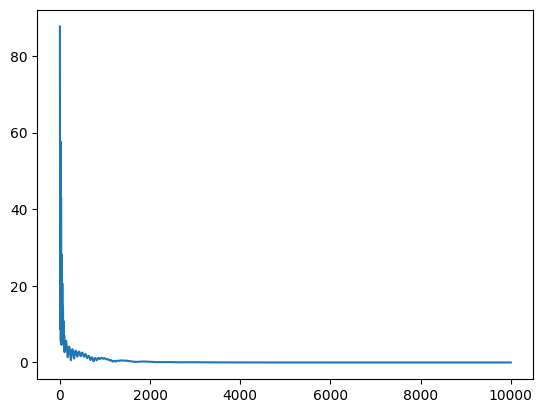

In [17]:
# Nesterov accelerated gradient descent for strongly convex functions
f3 = accel_gd_sc(J, Df, w0, la=1./L, kappa=L/l2, numb_iter=it_max)
plt.plot(f3[0])

# Exercício 5: Adagrad-Norm

Construa uma função `ad_grad_norm(J, Df, w0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `Df`, o ponto inicial `w0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `w0`:
\begin{align*}
w_{k+1}&:= w_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(w_j)\Vert_2^2}} \nabla f(w_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(Df(w))` em cada um dos iterados `w`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `b0=0.5` e `eta=1`.

In [18]:
# Função para o método Adagrad-Norm
def ad_grad_norm(J, Df, w0, b0=0.5, eta=1, numb_iter=100):
    w = w0.copy()  
    grad_norms = []  
    sum_sq_grad_norms = b0**2  

    for k in range(numb_iter):
        grad = Df(w)  
        grad_norm = np.linalg.norm(grad)  
        grad_norms.append(grad_norm)  

        # Atualiza a soma dos quadrados das normas do gradiente
        sum_sq_grad_norms += grad_norm**2

        # Calcula o passo adaptativo
        adapt_step = eta / np.sqrt(sum_sq_grad_norms)

        # Atualiza w usando o gradiente e o passo adaptativo
        w = w - adapt_step * grad

    return grad_norms, w

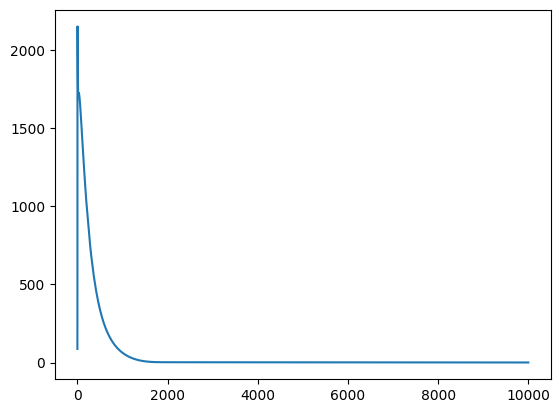

In [19]:
# Adagrad-Norm
f4 = ad_grad_norm(J, Df, w0, b0=0.5, eta=0.01, numb_iter=it_max)
plt.plot(f4[0])

# Exercício 6: Adam

Construa uma função `adam(Df, w0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `Df`, o ponto inicial `w0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `w0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(w_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(w_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
w_{k+1}[j] &:= w_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon }\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(Df(w))` em cada um dos iterados `w`, isto é, a sequência das normas dos gradientes de $w_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`. 

In [20]:
def adam(Df, w0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, numb_iter=100):
    w = w0.copy()  
    m = np.zeros_like(w)  
    v = np.zeros_like(w)  
    grad_norms = []  

    for k in range(numb_iter):
        grad = Df(w)  
        grad_norm = np.linalg.norm(grad)  
        grad_norms.append(grad_norm)  

        # Atualiza os momentos de primeira e segunda ordem
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        # Calcula as correções para bias dos momentos
        m_hat = m / (1 - beta1 ** (k + 1))
        v_hat = v / (1 - beta2 ** (k + 1))

        # Atualiza o vetor de parâmetros w
        w = w - (alpha / (np.sqrt(v_hat) + epsilon)) * m_hat

    return grad_norms, w 

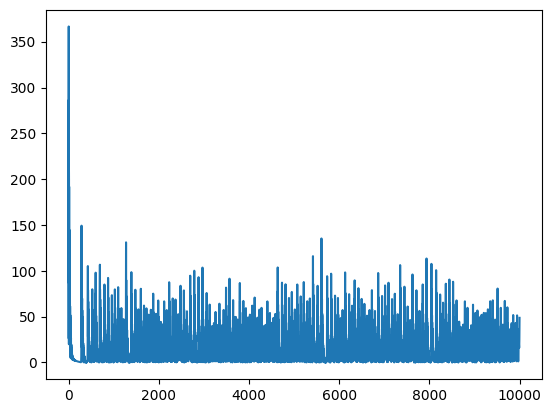

In [23]:
# Adam
f5 = adam(Df, w0, alpha=0.0001, beta1=0.9, beta2=0.99, epsilon=10**(-8), numb_iter=it_max)
plt.plot(f5[0])

# Exercício 7: 

Implemente num mesmo gráfico os erros $\Vert\nabla f(w_k)\Vert$ de cada método em função no número de iterações.

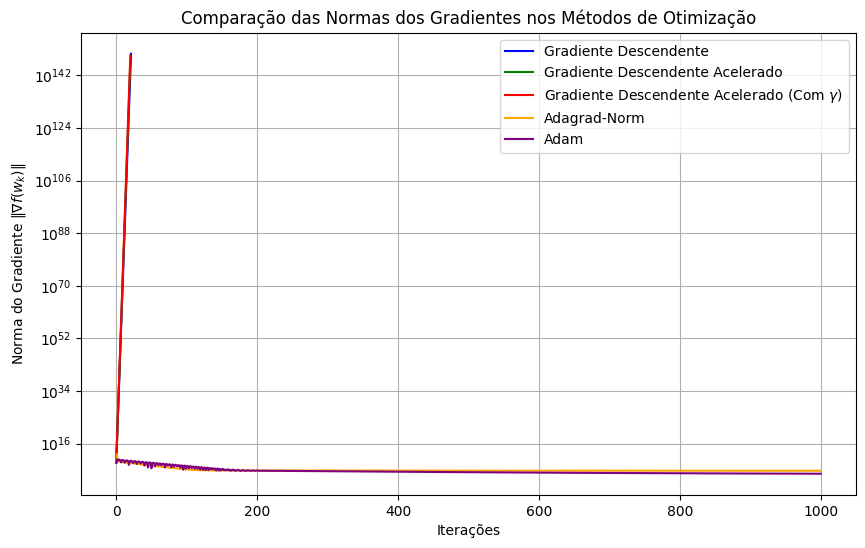

In [29]:
# Plotar as normas dos gradientes em função do número de iterações
plt.figure(figsize=(10, 6))

plt.plot(f1[0], label='Gradiente Descendente', color='blue')
plt.plot(f2[0], label='Gradiente Descendente Acelerado', color='green')
plt.plot(f3[0], label='Gradiente Descendente Acelerado (Com $\gamma$)', color='red')
plt.plot(f4[0], label='Adagrad-Norm', color='orange')
plt.plot(f5[0], label='Adam', color='purple')

# Ajustar os detalhes do gráfico
plt.xlabel('Iterações')
plt.ylabel('Norma do Gradiente $\\Vert \\nabla f(w_k) \\Vert$')
plt.title('Comparação das Normas dos Gradientes nos Métodos de Otimização')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Exercício 8:

Experimente com os hyper-parâmetros de Adagrad-Norm and Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 7. 

C:\Users\dudda\AppData\Local\Temp\ipykernel_6600\2321482861.py:6: RuntimeWarning: overflow encountered in matmul
  return 2 * X.T @ (X @ w - y) + 2 * l2 * w
C:\Users\dudda\AppData\Local\Temp\ipykernel_6600\2321482861.py:6: RuntimeWarning: invalid value encountered in matmul
  return 2 * X.T @ (X @ w - y) + 2 * l2 * w


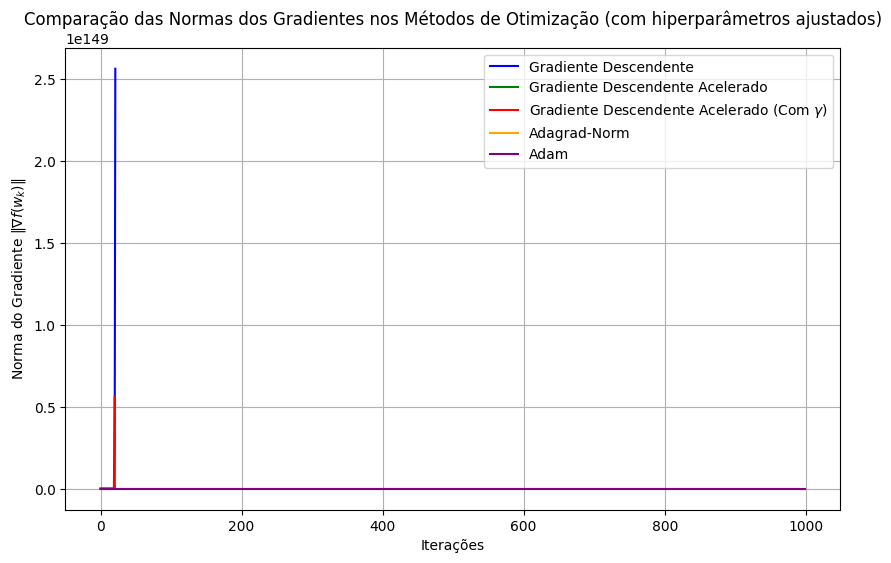

In [ ]:
# Defina as funções f e df corretamente (exemplo simples de funções)
def f(w, X, y, l2):
    return np.linalg.norm(X @ w - y)**2 + l2 * np.linalg.norm(w)**2

def df(w, X, y, l2):
    return 2 * X.T @ (X @ w - y) + 2 * l2 * w

# Função do Gradiente Descendente (GD)
def gd(J, df, w0, la, numb_iter):
    w = w0
    norms = []
    for _ in range(numb_iter):
        grad = df(w)
        w = w - la * grad
        norms.append(np.linalg.norm(grad))  # Norma do gradiente
    return norms, w

# Testando diferentes hiperparâmetros
b0_adagrad = 0.5  # Valor padrão de b0
eta_adagrad = 0.1  # Tentando aumentar a taxa de aprendizado

# Adam
alpha_adam = 0.001  # Taxa de aprendizagem padrão
beta1_adam = 0.9  # Valor padrão de beta1
beta2_adam = 0.999  # Valor padrão de beta2
epsilon_adam = 1e-8  # Termo de estabilização

# Inicialização das variáveis (exemplo)
w0 = np.zeros(X.shape[1])  # Supondo que X tem forma (n_samples, n_features)
it_max = 1000  # Número máximo de iterações

# Executar cada um dos métodos e coletar as normas dos gradientes
f1 = gd(J=lambda w: f(w, X, y, l2), df=lambda w: df(w, X, y, l2), w0=w0, la=1./L, numb_iter=it_max)
f2 = accel_gd(J=lambda w: f(w, X, y, l2), df=lambda w: df(w, X, y, l2), w0=w0, la=1./L, numb_iter=it_max)
f3 = accel_gd_sc(J=lambda w: f(w, X, y, l2), df=lambda w: df(w, X, y, l2), w0=w0, la=1./L, kappa=L/l2, numb_iter=it_max)
f4 = ad_grad_norm(J=lambda w: f(w, X, y, l2), Df=lambda w: df(w, X, y, l2), w0=w0, b0=b0_adagrad, eta=eta_adagrad, numb_iter=it_max)
f5 = adam(Df=lambda w: df(w, X, y, l2), w0=w0, alpha=alpha_adam, beta1=beta1_adam, beta2=beta2_adam, epsilon=epsilon_adam, numb_iter=it_max)

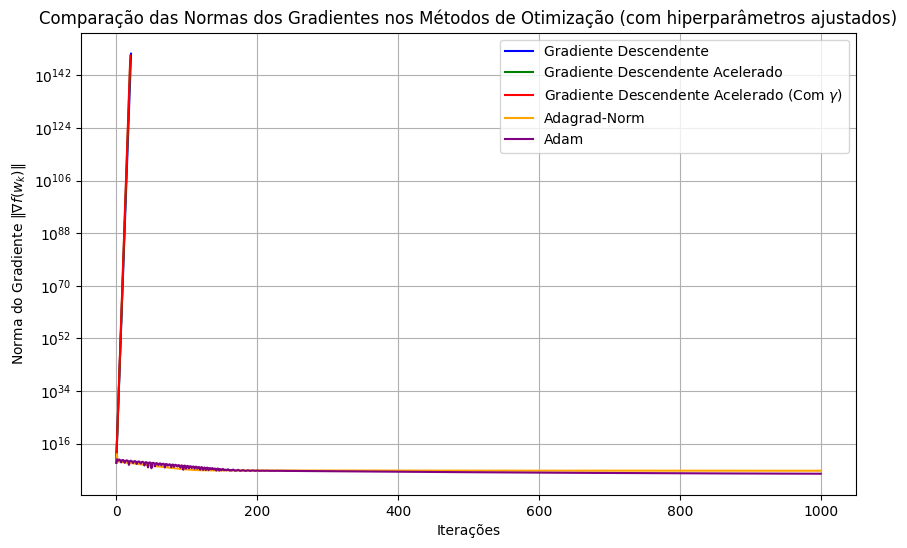

In [31]:
# Plotar as normas dos gradientes em função do número de iterações
plt.figure(figsize=(10, 6))

plt.plot(f1[0], label='Gradiente Descendente', color='blue')
plt.plot(f2[0], label='Gradiente Descendente Acelerado', color='green')
plt.plot(f3[0], label='Gradiente Descendente Acelerado (Com $\gamma$)', color='red')
plt.plot(f4[0], label='Adagrad-Norm', color='orange')
plt.plot(f5[0], label='Adam', color='purple')

# Ajustar os detalhes do gráfico
plt.xlabel('Iterações')
plt.ylabel('Norma do Gradiente $\\Vert \\nabla f(w_k) \\Vert$')
plt.title('Comparação das Normas dos Gradientes nos Métodos de Otimização (com hiperparâmetros ajustados)')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()